# BMI Regression using Dense Layers

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv('data/diabetes.csv')
data = data[data['BMI'] > 0].drop('Outcome', axis=1)

X = data.drop('BMI', axis=1).values
y = data['BMI'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [5]:
class BMIRegressionNet(nn.Module):
    def __init__(self, input_size):
        super(BMIRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
input_size = X_train_scaled.shape[1]
net = BMIRegressionNet(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
num_epochs = 400
batch_size = 32
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    net.eval()
    with torch.no_grad():
        train_pred = net(X_train_tensor)
        train_loss = criterion(train_pred, y_train_tensor)
        val_pred = net(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
        
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [100/400], Train Loss: 30.0953, Val Loss: 27.1899
Epoch [200/400], Train Loss: 27.1848, Val Loss: 25.2493
Epoch [300/400], Train Loss: 25.6120, Val Loss: 25.3943
Epoch [400/400], Train Loss: 24.5871, Val Loss: 25.4806


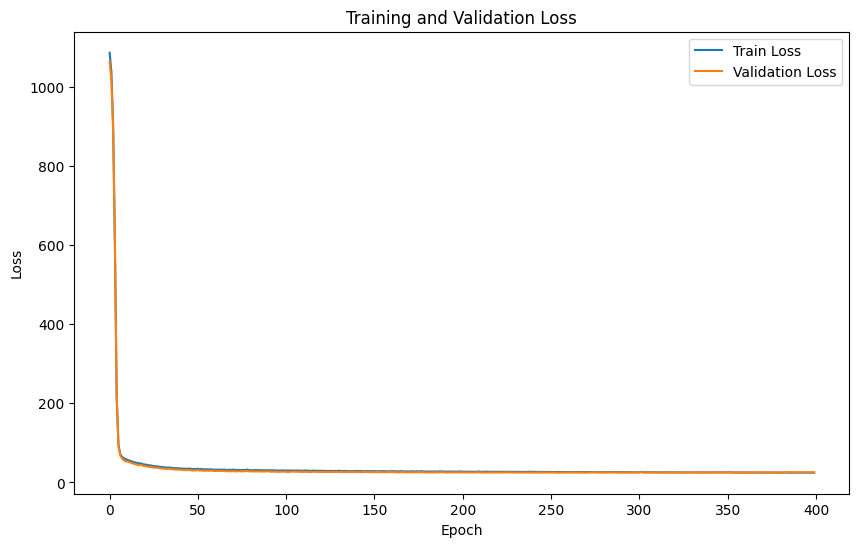

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [10]:
net.eval()
with torch.no_grad():
    y_pred = net(X_test_tensor).numpy().flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Final Results:')
print(f'\tMean Absolute Error: {mae:.4f}')
print(f'\tMean Squared Error: {mse:.4f}')
print(f'\tr2 Score: {r2:.4f}')

Final Results:
Mean Absolute Error: 4.0410
Mean Squared Error: 25.4806
R2 Score: 0.3724


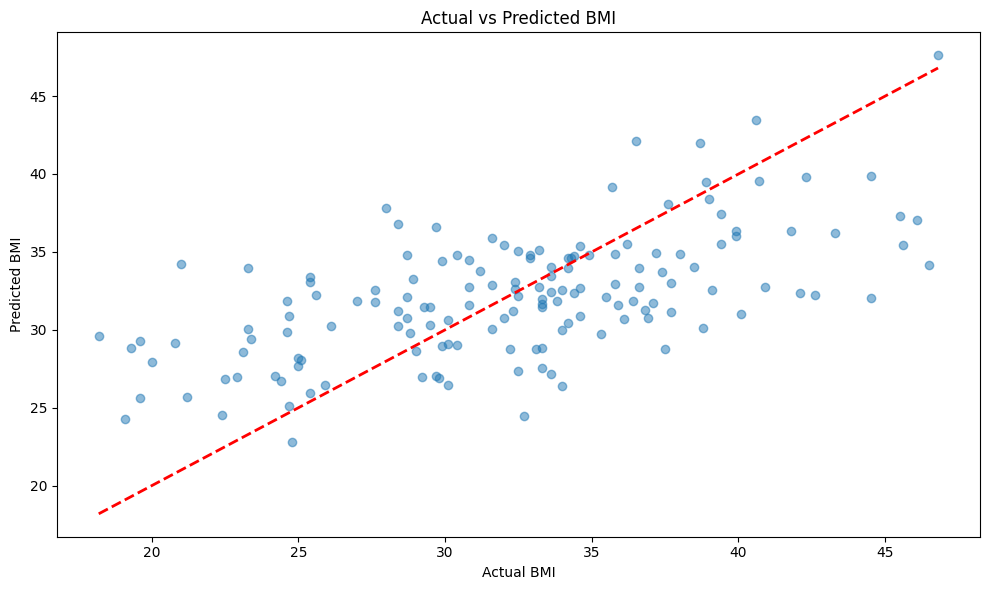

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Actual vs Predicted BMI')
plt.tight_layout()
plt.show()
plt.close()

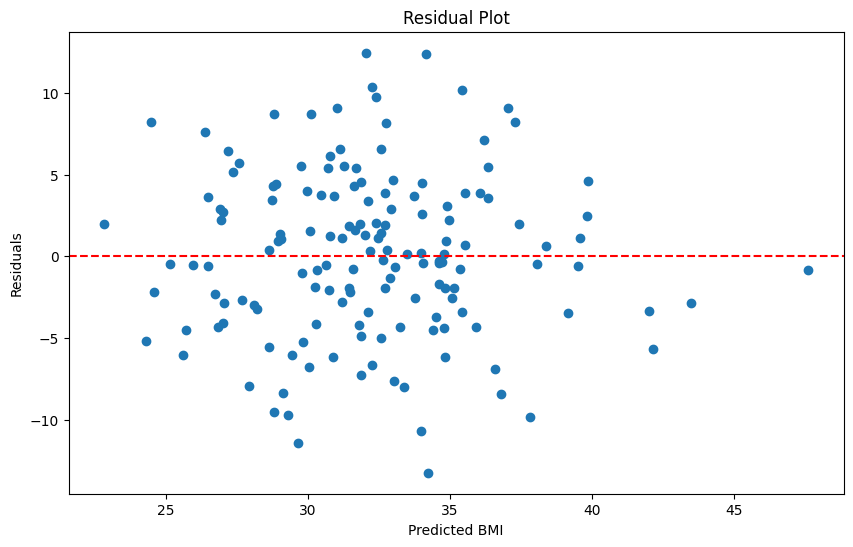

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted BMI')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
plt.close()

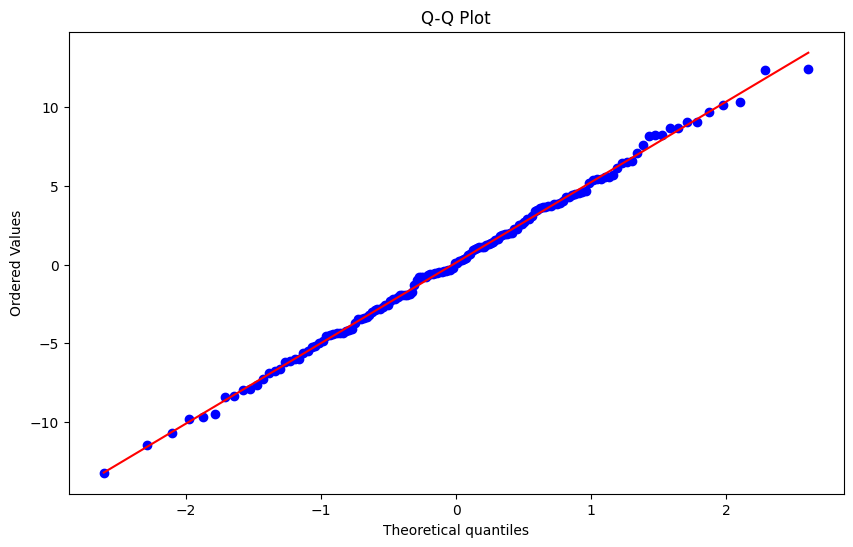

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot")
plt.show()
plt.close()

In [14]:
feature_importance = []
for i in range(input_size):
    X_test_mod = X_test_scaled.copy()
    X_test_mod[:, i] = 0
    X_test_mod_tensor = torch.FloatTensor(X_test_mod)
    with torch.no_grad():
        y_pred_mod = net(X_test_mod_tensor).numpy().flatten()
    mse_mod = mean_squared_error(y_test, y_pred_mod)
    importance = mse_mod - mse
    feature_importance.append(importance)

feature_importance = pd.DataFrame({
    'feature': data.drop('BMI', axis=1).columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                    feature  importance
3             SkinThickness   16.110408
6                       Age    1.895613
1                   Glucose    1.633421
0               Pregnancies    0.964590
2             BloodPressure    0.806954
4                   Insulin    0.042375
5  DiabetesPedigreeFunction   -0.120141
